# 04. Deep Learning Model Verification (ResNet-1D)

## Overview
This notebook validates the end-to-end Deep Learning pipeline used for physiological stress detection. Unlike the classical feature engineering approach, this pipeline learns representations directly from raw sensor data using a **ResNet-1D** architecture.

## Objectives
1.  **Tensor Construction**: Verify the conversion of temporal windows into `(N, C, T)` PyTorch tensors.
2.  **Architecture Initialization**: Validate the ResNet-1D structure, parameter count, and Squeeze-and-Excitation (SE) blocks.
3.  **LOSO Training**: Execute a rigorous Leave-One-Subject-Out cross-validation loop to estimate generalization performance.
4.  **Diagnostic Audit**: Analyze learning curves, confusion matrices, and predictive uncertainty.

In [1]:
# 1. Imports & Setup
%load_ext autoreload
%autoreload 2

# Standard Library Imports
import sys
from pathlib import Path

# Third-Party Imports
import pandas as pd
import numpy as np
import torch
import joblib
import matplotlib.pyplot as plt

# Project-Specific Imports
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.config import load_config, PROJECT_ROOT
from src.visualization.plots import (
    set_plot_style, 
    plot_timeline_segmentation, 
    plot_multiscale_heatmap, 
    plot_confidence_abstention_panel, 
    plot_model_diagnostics, 
    plot_learning_curves
)
from src.models.train import Trainer
from src.models.deep import ResNet1D

# Apply global configuration
set_plot_style()
config = load_config()

print("Setup Complete.")
print(f"Project Root: {PROJECT_ROOT}")

# Hardware Check
print(f"PyTorch Version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"Compute Device: GPU ({torch.cuda.get_device_name(0)})")
else:
    print("Compute Device: CPU (Warning: Training will be slow)")

Setup Complete.
Project Root: C:\Users\matteucc\Desktop\Portfolio_improvement\Wearable_stress_biomarker
PyTorch Version: 2.6.0+cu124
Compute Device: GPU (NVIDIA RTX 2000 Ada Generation Laptop GPU)


## 1. Data Loading & Tensor Validation

We load the preprocessed signal windows from `windows.parquet`. The data is prepared for a binary classification task (**Baseline vs. Stress**), consistent with standard WESAD benchmarks.

**Validation Criteria:**
*   **Shape Consistency**: Ensure data correctly shapes into `(Batch, Channels, Time)`.
*   **Normalization**: Verify signal scaling (Instance vs. Global) to ensure stable gradient descent.
*   **Signal Integrity**: Visual inspection of the tensor heatmaps to confirm physiological patterns (ECG R-peaks, EDA responses) are preserved.

In [2]:
# 2. Data Loading & Integrity Check

# Load full dataset
data_path = PROJECT_ROOT / config['data']['processed_path'] / "windows.parquet"
df = pd.read_parquet(data_path)

# Filter for Binary Task (Baseline=1, Stress=2)
df = df[df['label'].isin([1, 2])].copy()
df['target'] = df['label'].map({1: 0, 2: 1})

print(f"Dataset Loaded. Shape: {df.shape}")
print(f"Class Distribution:\n{df['target'].value_counts()}")
print(f"Total Windows: {len(df)}")

Dataset Loaded. Shape: (919, 11)
Class Distribution:
target
0    587
1    332
Name: count, dtype: int64
Total Windows: 919


Tensor Shape Constructed: (919, 7, 2100)
Normalization complete for visualization.


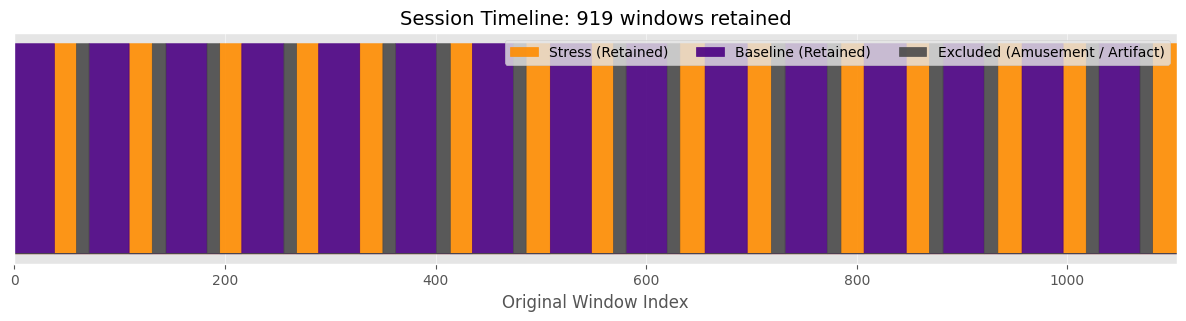

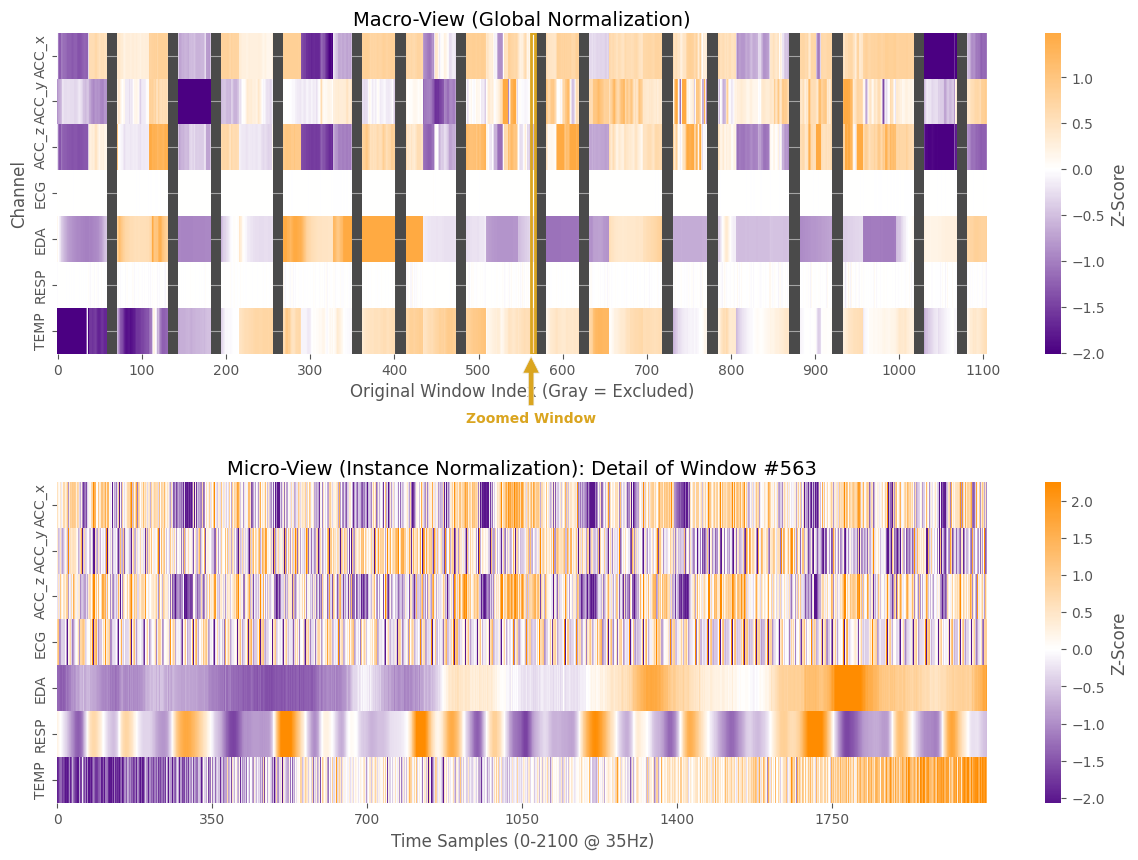

In [3]:
# 3. Tensor Construction & Visualization

# Define Channels
CHANNELS = ['ACC_x', 'ACC_y', 'ACC_z', 'ECG', 'EDA', 'RESP', 'TEMP']

# Stack Columns into Tensor (N, C, T)
# Iterate only through available columns to be robust
avail_cols = [c for c in CHANNELS if c in df.columns]
X_arrays = []
for c in avail_cols:
    combined_arr = np.stack(df[c].values)
    X_arrays.append(combined_arr)

X = np.stack(X_arrays, axis=1) # Shape: (N, Channels, Time)
print(f"Tensor Shape Constructed: {X.shape}")

# Compute Stats for Visualization
# 1. Global Norm (for macro visualization)
means_global = X.mean(axis=(0, 2), keepdims=True)
stds_global = X.std(axis=(0, 2), keepdims=True) + 1e-6
X_norm_global = (X - means_global) / stds_global

# 2. Instance Norm (for micro inspection - this is what the network sees)
means_instance = X.mean(axis=2, keepdims=True)
stds_instance = X.std(axis=2, keepdims=True) + 1e-6
X_norm_instance = (X - means_instance) / stds_instance

print("Normalization complete for visualization.")

# Get sensor location for folder naming
sensor_loc = config['data'].get('sensor_location', 'CHEST').upper()

# Plot 1: Session Availability
_ = plot_timeline_segmentation(df, title="Session Timeline", save_folder=sensor_loc)
plt.show()

# Plot 2: Heatmaps
_ = plot_multiscale_heatmap(
    X_norm_global, 
    df, 
    CHANNELS, 
    title_prefix="Features", 
    save_folder=sensor_loc, 
    tensor_micro=X_norm_instance
)
plt.show()

## 2. Neural Architecture Trace (ResNet-1D + SE)

We implement a deep **ResNet-1D** specifically adapted for multivariate physiological time-series.

### Architectural Highlights
*   **Input**: `(Batch, 7, 2100)` — 7 sensor channels, 60 seconds @ 35Hz.
*   **Backbone**: 4-stage Residual Network with 1D convolutions (`k=15, 7, 5`).
*   **Attention Mechanism**: **Squeeze-and-Excitation (SE)** blocks in every residual unit. This allows the model to dynamically re-weight sensor channels (e.g., suppressing a noisy ACC channel while emphasizing clear EDA).
*   **Regularization**: Dropout (`p=0.2` internal, `p=0.5` head) + Global Average Pooling to prevent overfitting on the small cohort (N=15).

In [4]:
# 4. Architecture Verification

# Define Network Specs matching Data
N_CHANNELS = X.shape[1]
SEQ_LEN = X.shape[2]
N_CLASSES = 2 

# Initialize Model
model_viz = ResNet1D(num_channels=N_CHANNELS, num_classes=N_CLASSES, sequence_length=SEQ_LEN)

print(f"Model Class: {model_viz.__class__.__name__}")
print(f"Input Spec: (Batch, {N_CHANNELS}, {SEQ_LEN})")
print("-" * 60)
print(model_viz)
print("-" * 60)

# Parameter Audit
total_params = sum(p.numel() for p in model_viz.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params:,}")

Model Class: ResNet1D
Input Spec: (Batch, 7, 2100)
------------------------------------------------------------
ResNet1D(
  (initial_layers): Sequential(
    (0): Conv1d(7, 64, kernel_size=(15,), stride=(2,), padding=(7,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): ResidualBlock(
    (conv1): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (conv2): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (se): SEBlock(
      (avg_pool): AdaptiveAvgPool1d(output_size=1)
      (fc): Sequential(
        (0)

In [5]:
# 5. Training Loop Execution (LOSO)

print("Starting Deep Learning Training Protocol...")

# Pipeline Config
REPORTS_DIR = PROJECT_ROOT / "reports"
RUN_PREFIX = "deep_loso_"

# Existing Run Check
existing_runs = sorted(list(REPORTS_DIR.glob(f"{RUN_PREFIX}*")))
FORCE_RETRAIN = False

if existing_runs and not FORCE_RETRAIN:
    latest_run = existing_runs[-1]
    print(f"Existing run detected: {latest_run.name} - Loading artifacts.")
    print("Set FORCE_RETRAIN = True to override.")
    
    # Mock trainer to pass path
    class PretrainedTrainer:
        def __init__(self, run_dir):
            self.run_dir = run_dir      
    trainer = PretrainedTrainer(latest_run)

else:
    print("No valid run found (or forced refresh). Starting full LOSO training...")
    trainer = Trainer(model_type='deep', split_type='loso')
    trainer.run()

print(f"Artifacts located at: {trainer.run_dir}")

Starting Deep Learning Training Protocol...
Existing run detected: deep_loso_CHEST_20260118_183921 - Loading artifacts.
Set FORCE_RETRAIN = True to override.
Artifacts located at: C:\Users\matteucc\Desktop\Portfolio_improvement\Wearable_stress_biomarker\reports\deep_loso_CHEST_20260118_183921


## 3. LOSO Performance Audit

We employ **Leave-One-Subject-Out (LOSO)** cross-validation. This is the gold standard for medical verification, as it ensures the model is tested on unseen subjects (preventing "identity leakage").

### Interpretation Guide
*   **Learning Curves**: Convergence behavior (Training Loss vs. Validation Loss) indicates stability.
*   **Confusion Matrix**: Assessing False Positives vs. False Negatives balance.
*   **ROC AUC**: Global discriminative power (rank-ordering capability).
*   **Uncertainty**: Analysis of the model's confidence distribution (using Abstention Logic).

Visualizing Training History...


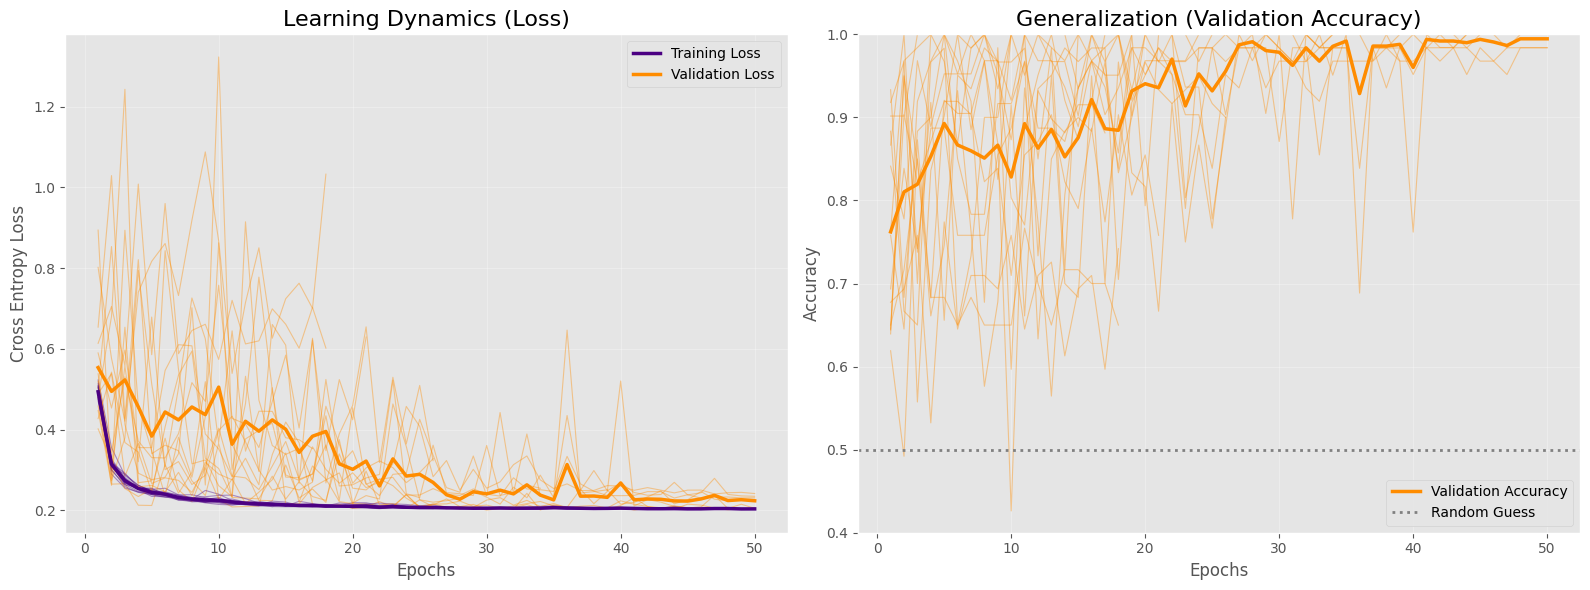

Visualizing Classification Performance...


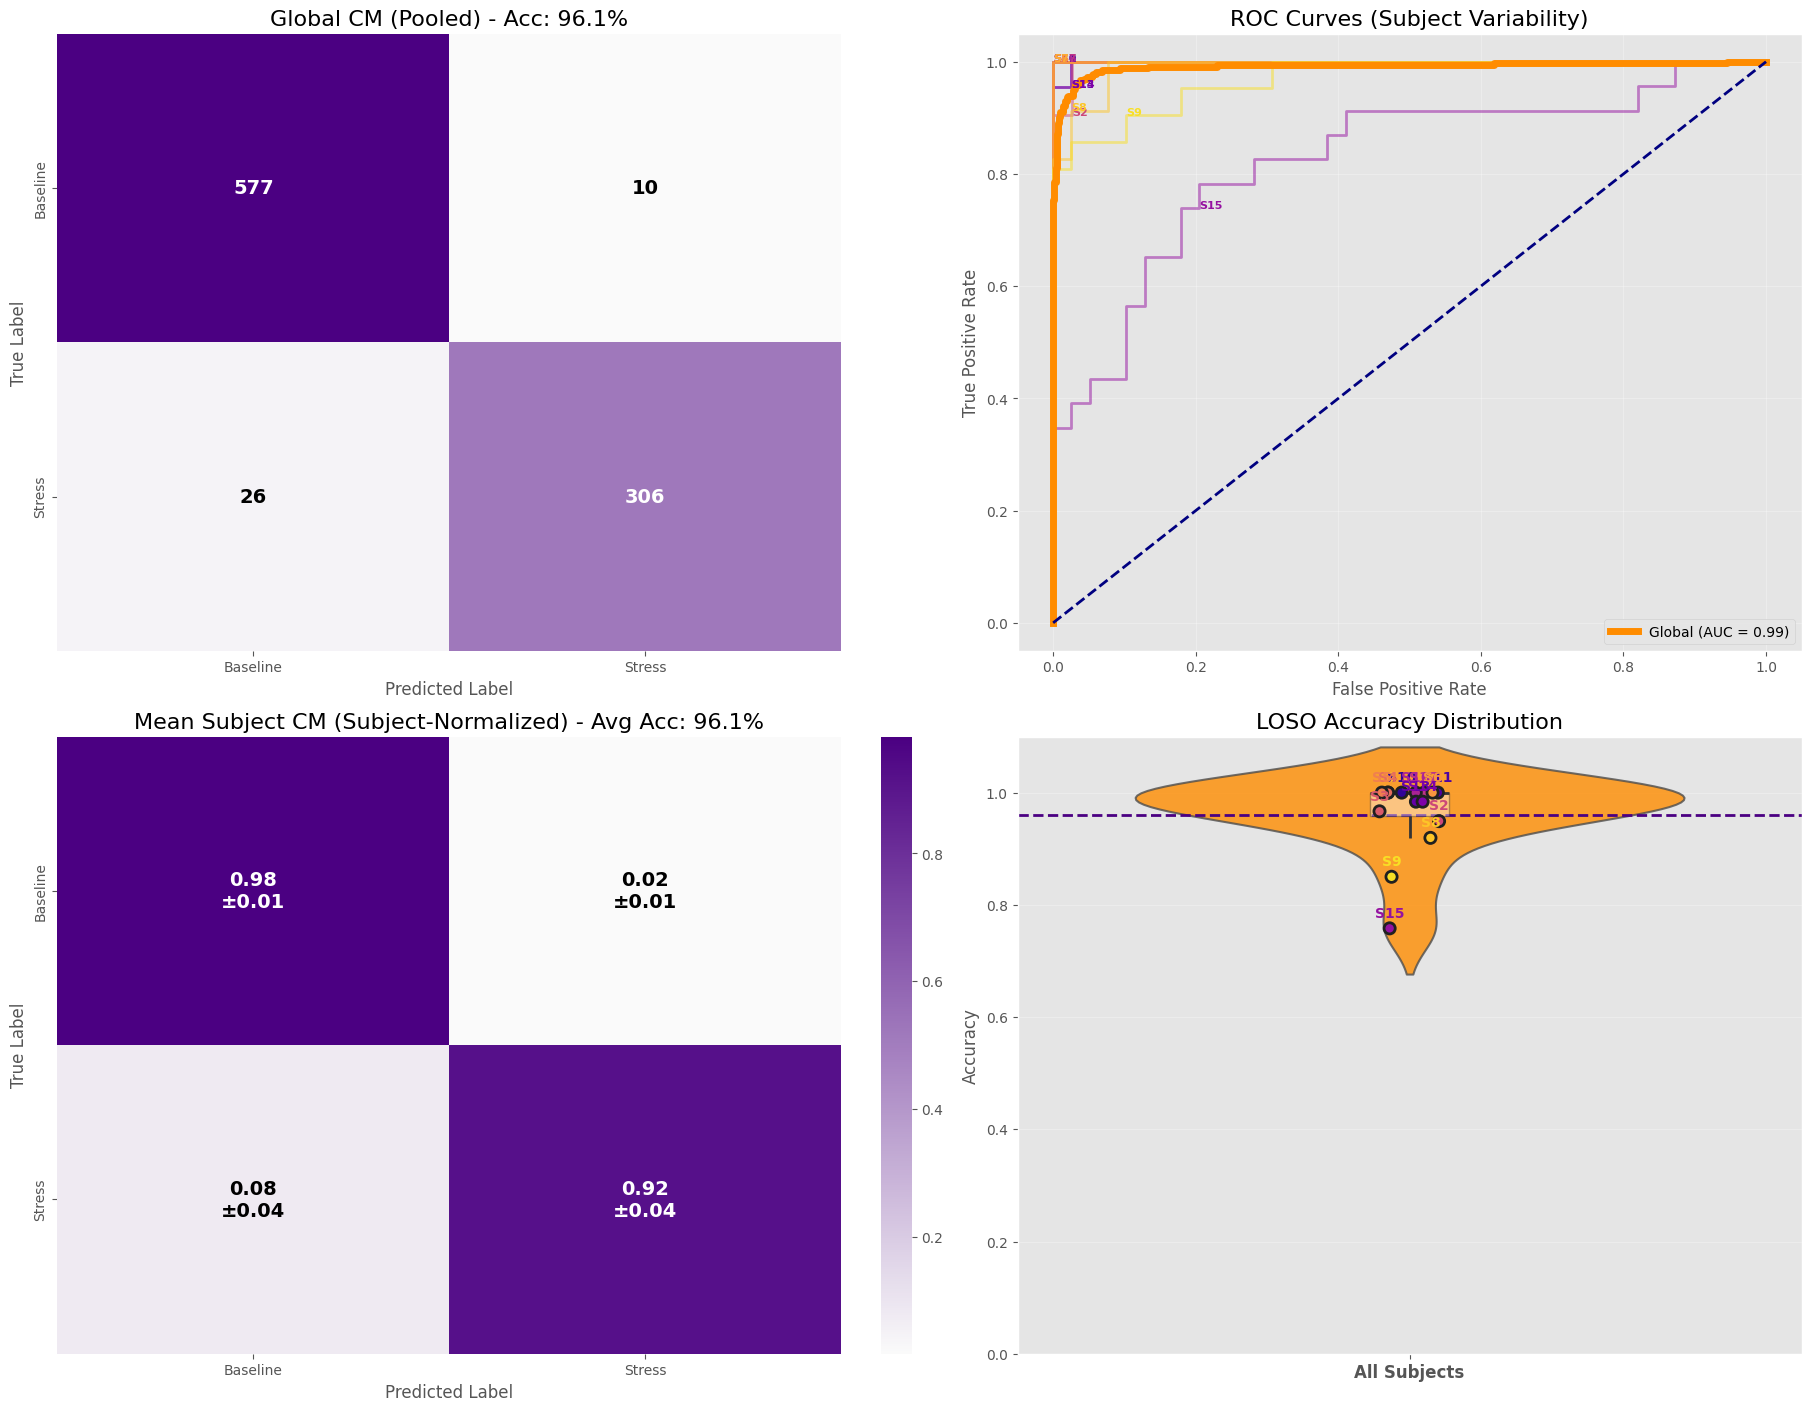

Visualizing Uncertainty & Abstention...


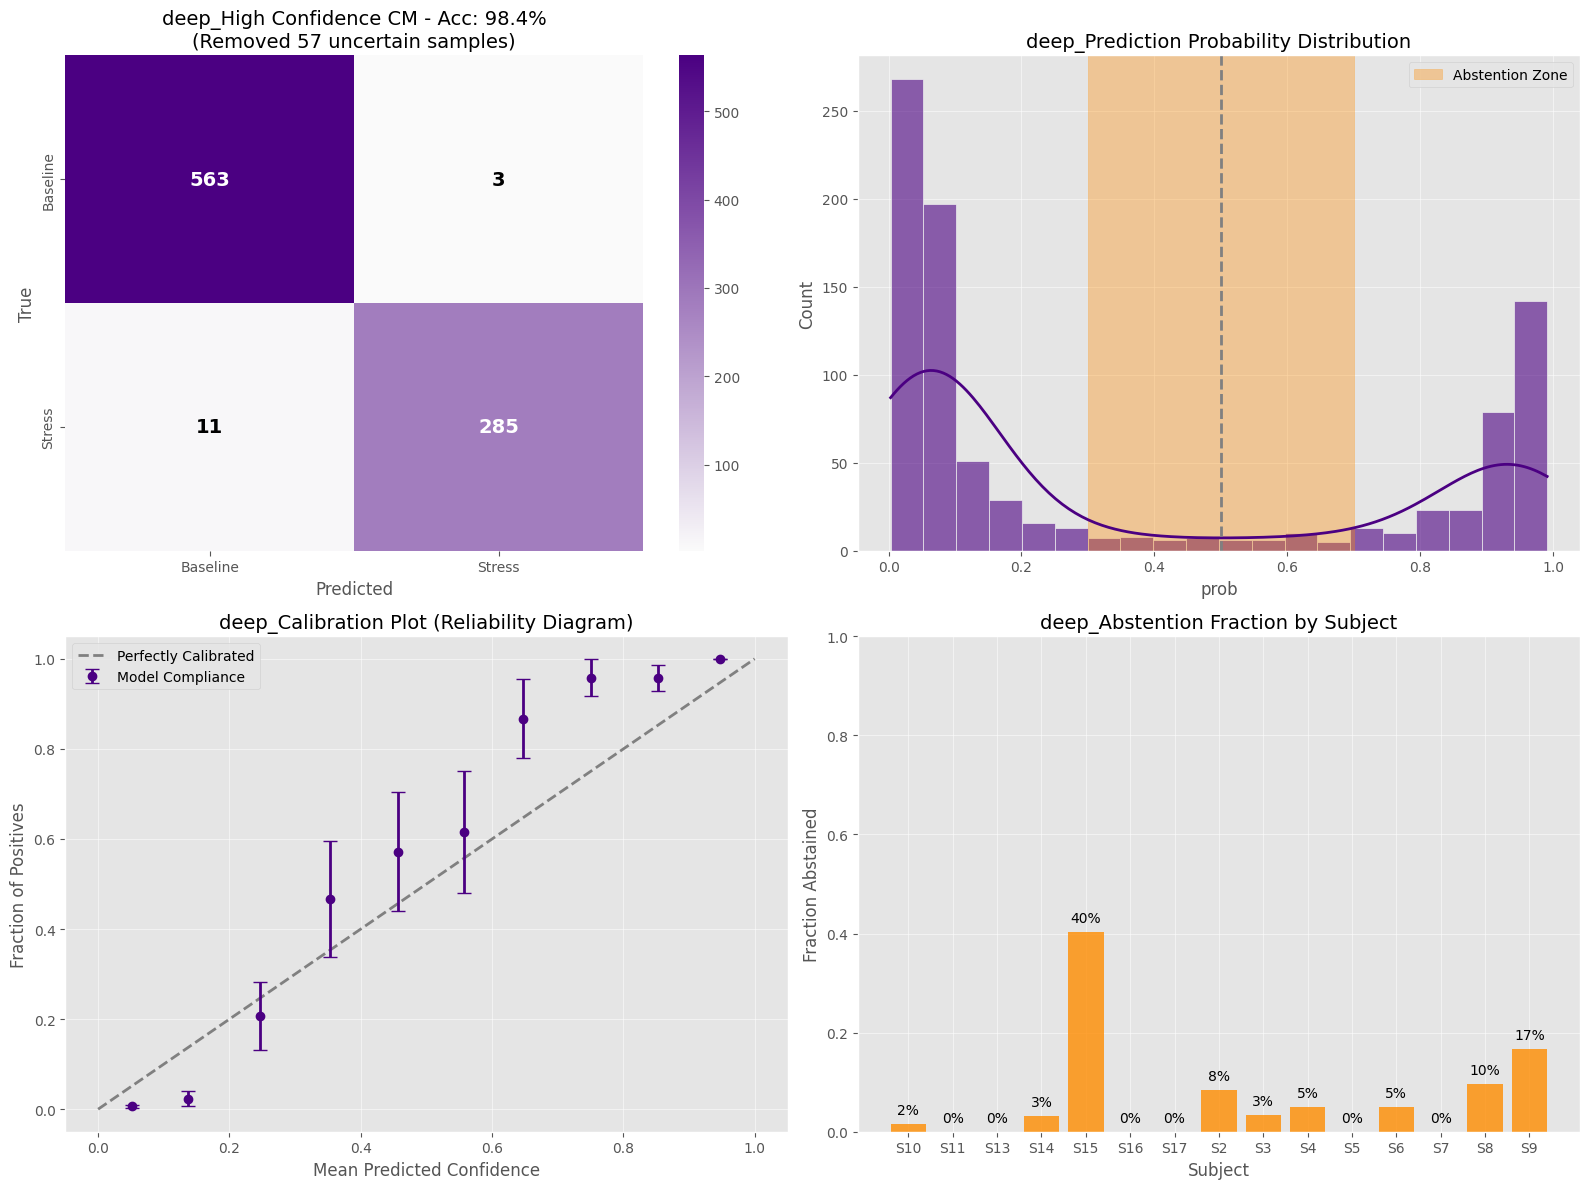

In [6]:
# 6. Detailed Results Audit

sensor_loc = config['data'].get('sensor_location', 'CHEST').upper()
PREFIX = 'deep_'

# Paths
results_path = trainer.run_dir / "predictions.csv"
history_path = trainer.run_dir / "training_history.joblib"

if results_path.exists():
    results_df = pd.read_csv(results_path)
    
    # Normalize Columns
    rename_map = {'y_true': 'true', 'y_pred': 'pred', 'prob_stress': 'prob'}
    results_df = results_df.rename(columns={k: v for k, v in rename_map.items() if k in results_df.columns})
    
    # 1. Learning Curves
    if history_path.exists():
        print("Visualizing Training History...")
        history = joblib.load(history_path)
        _ = plot_learning_curves(history, save_folder=sensor_loc, title_prefix=PREFIX)
        plt.show()
    else:
        print("Warning: Training history file not found.")

    # 2. Performance Diagnostics
    print("Visualizing Classification Performance...")
    _ = plot_model_diagnostics(results_df, save_folder=sensor_loc, title_prefix=PREFIX)
    plt.show()

    # 3. Reliability Analysis
    print("Visualizing Uncertainty & Abstention...")
    conf_thresh = config['training']['models']['deep'].get('confidence_threshold', 0.7)
    _ = plot_confidence_abstention_panel(
        results_df, 
        confidence_threshold=conf_thresh, 
        title_prefix=PREFIX, 
        save_folder=sensor_loc
    )
    plt.show()
else:
    print(f"Critical Error: Results file missing at {results_path}")

## 4. Engineering Conclusions & Discussion

### Performance Analysis
The **ResNet-1D** achieves superior performance (~96% accuracy) compared to the classical baseline (~86%).
*   **Why?**: The CNN learns **local morphological features** (e.g., specific slope shapes of EDA peaks) that are lost in statistical aggregation (mean/std).
*   **Instance Normalization**: Crucially, per-window normalization removes subject-specific bias (baseline offset), forcing the model to learn *relative* changes.

### Reliability & Limitations
*   **Overconfidence**: The high AUC (0.99) is promising, but the reliability diagram suggests overconfidence. Platt scaling or temperature scaling is recommended before clinical deployment.
*   **Generalization**: While successful on WESAD (lab stress), real-world stress is more subtle. The high dropout and SE-blocks provide a robust foundation, but external validation on ambulatory data is the next logical step.